#Tasks
The mouse ate cheese disgrafully with a mouth full of blood
1. Predicate identification (find the verb): ate
2. associate the predicate with meaning: ate-> eat
3. identify arguments: mouse, cheese
4. argument classification: mouse - agent, cheese - patient


# Downlaods, installs and imports



In [1]:
# !pip install Flask==2.0.3
# !pip install requests==2.27.1
# !pip install scikit-learn==1.0.2
# !pip install numpy==1.21.5
# !pip install tqdm==4.63.0
# # !pip install torch==1.9.0
!pip install rich==12.0.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 9.8 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 


In [2]:
import torch
from torch import nn
from torch import nn
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop
import torch.nn.functional as F
from typing import List, Dict

import numpy as np
import random
import re

In [3]:
torch.cuda.is_available()

True

In [4]:
import os
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
from rich.progress import track

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/SapienzaNLP/nlp2022-hw2.git

Mounted at /content/drive
Cloning into 'nlp2022-hw2'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 49 (delta 21), reused 42 (delta 15), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
# #get GloVe embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# #tried with 100d, 200d, 300d, finally 50d are chosen
# !rm glove.6B.100d.txt
# !rm glove.6B.200d.txt
# # !rm glove.6B.300d.txt
# !rm glove.6B.zip

Read data EN

In [9]:
project_path = '/content/drive/MyDrive/Colab Notebooks/NLP HW2'
en_train_path = os.path.join(project_path, 'data_hw2', 'EN', 'train.json')
en_dev_path = os.path.join(project_path, 'data_hw2', 'EN', 'dev.json')

# Vocabulary




In [10]:
glove_path = '/content/drive/MyDrive/Colab Notebooks/NLP_HW1/glove_pretrained/glove.6B.100d.txt'
# glove_path_d = 'glove.6B.50d.txt'

In [11]:

word_vector = pd.read_csv(glove_path, sep=" ", header=None,engine='c', quoting=csv.QUOTE_NONE, index_col=0)

glove = {key: val.values for key, val in word_vector.T.items()}

In [12]:
def word2id_builder(word_dataset):
  word2id_dict = {"<UNK>":1, "<PAD>":0}
  id2word_dict = {1: "<UNK>",0: "<PAD>"}
  for i, word in enumerate(word_dataset):
    if word not in word2id_dict:
      id = len(word2id_dict)
      word2id_dict[word ] = id
      id2word_dict[id] = word
  return word2id_dict, id2word_dict
words = list(glove.keys())
word2id_dict, id2word_dict = word2id_builder(words)

In [13]:
weight_matrix = np.asarray(list(glove.values()), dtype=np.float32)
vocab_size, emb_dim  = weight_matrix.shape

# for <UNK> take avg of vectors
average_vec = np.mean(weight_matrix, axis=0)
weight_matrix = np.concatenate((average_vec.reshape(1, emb_dim), weight_matrix), axis = 0)
# for <PAD> instert all zeros
weight_matrix = np.concatenate((np.zeros((1, emb_dim)), weight_matrix), axis = 0)

vocab_size  = weight_matrix.shape
print("Vocabulary shape: {}".format(vocab_size))
print("Embedding dimension: {}".format(emb_dim))

weights_matrix_torch = torch.tensor(weight_matrix, dtype=torch.float)

Vocabulary shape: (400000, 100)
Embedding dimension: 100


In [14]:
def word2id(w: str)-> List:
  id = word2id_dict[w] if w in word2id_dict else word2id_dict["<UNK>"] 
  return id

In [15]:
# Taken from utils.read_dataset
def read_dataset(path: str):
    with open(path) as f:
        dataset = json.load(f)

    sentences, labels = {}, {}
    for sentence_id, sentence in dataset.items():
        sentence_id = sentence_id
        sentences[sentence_id] = {
            "words": sentence["words"],
            "lemmas": sentence["lemmas"],
            "pos_tags": sentence["pos_tags"],
            "dependency_heads": [int(head) for head in sentence["dependency_heads"]],
            "dependency_relations": sentence["dependency_relations"],
            "predicates": sentence["predicates"],
        }

        labels[sentence_id] = {
            "predicates": sentence["predicates"],
            "roles": {int(p): r for p, r in sentence["roles"].items()}
            if "roles" in sentence
            else dict(),
        }
    return sentences, labels

In [16]:
sentences, labels = read_dataset(en_train_path)
role_tags = set()

for sent_id in labels:
  roles = list(labels[sent_id]['roles'].values())
  for sent in roles:
    for role in sent:
      role_tags.add(role)
role_tags.add('<PAD>')
tags = list(role_tags)
tags.sort()

id2tag_dict = {i: key for i, key in enumerate(tags)}
tag2id_dict = {key: value for value, key in id2tag_dict.items()}

In [17]:
# def tags2ids(labels: List[List]) -> List[List]:
#   return [[tag2id_dict[label] for label in label_sent] for label_sent in labels]

def tags2ids_(labels: List) -> List[List]:
  for label in labels:
    if not label in tag2id_dict:
      print(label)
      return []
  return [tag2id_dict[label] for label in labels]

def ids2tags(label_ids: List[List]) -> List[List]:
  return [[id2tag_dict[id] for id in ids] for ids in label_ids]

# Dataset class

In [18]:
#preprocessong function
def preprocess(word: str) -> str: 
    return re.sub('[\.,:;!@#$\(\)\-&\\<>/0-9]', '', word).lower()

def sentence2vector(sentenceList: List) -> List:    
    sentence_word_vector = [word2id_dict[preprocess(w)] if preprocess(w) in word2id_dict else word2id_dict["<UNK>"] for w in sentenceList ]
    return sentence_word_vector


In [19]:
def predicate_ids(predicates: List) -> List:
  out = []
  n_words = len(predicates)
  predicate_pos = []
  for pos, word in enumerate(predicates):
    if word != '_': # word is a predicate
      predicate_pos.append(pos)
      sent = [word2id("<PAD>")]*n_words
      predicate_word = preprocess(word).split("_")
      for pw in predicate_word:
        if word2id(pw) != 1:
          break
      sent[pos] = word2id(pw)
      out.append(sent)
  if out==[]:
    out = [[0]*n_words]
  return out, predicate_pos

# def predicates_binary(predicates: List) -> List:
#   out = []
#   n_words = len(predicates)
#   for pos, word in enumerate(predicates):
#     if word != '_': # word is a predicate
#       sent = [0]*n_words
#       sent[pos] = 1
#       out.append(sent)
#   if out==[]:
#     out = [[0]*n_words]
#   return out

def arg_binary(args: List) -> List:
  return [1 if arg!='_' else 0 for arg in args]

def get_true_labels(roles, n_words) -> List:
  if not type(roles) is dict: #is float:
    return [[0]*n_words]
  binary_args_per_predicates = []
  pred_rs = list(roles.keys())
  for pred in pred_rs:
    binary_args_per_predicates.append(arg_binary(roles[pred]))
  if binary_args_per_predicates==[]:
    binary_args_per_predicates = [[0]*n_words]
  return binary_args_per_predicates

def get_true_labels_for_classification(roles, n_words) -> List:
  if not type(roles) is dict: #is float:
    return [[0]*n_words]
  args_per_predicates = []
  
  for pred in roles.keys():
    
    args_per_predicates.append(tags2ids_(roles[pred]))
  if args_per_predicates==[]:
    args_per_predicates = [[0]*n_words]
  return args_per_predicates

In [20]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, dataset_path: str, device = 'cpu'):
        self.words = []
        self.lemmas = []
        self.predicates = []
        self.labels = []
        self.device = device
        self.build(dataset_path)

    def build(self, dataset_path: str) -> None:
        sentences, labels = read_dataset(dataset_path)
        
        for sentence_id in track(sentences, description="Loading dataset"):
          sentence = sentences[sentence_id]
          label = labels[sentence_id]

          predicate_binary, _ = predicate_ids(list(sentence["predicates"]))
          args = get_true_labels_for_classification(label["roles"], len(sentence["words"]))
          # Makes n (number of predicates in a sentence) dublicates of words and lemmas
          word_ids = [sentence2vector(sentence["words"]) for n in range(len(predicate_binary))]
          lemma_ids = [sentence2vector(sentence["lemmas"]) for n in range(len(predicate_binary))]
          
          # To ensure sentence has the same number of dublicates in each category
          assert len(predicate_binary) == len(args)

          self.words.extend(word_ids)
          self.lemmas.extend(lemma_ids)
          self.predicates.extend(predicate_binary)
          self.labels.extend(args)
          
        print("{} sentences in original".format(len(sentences)))
        print("{} sentences with duplicates". format(len(self.words)))
  
    def batch_gen(self, batch_size, shuffle=False, dropout=True) :
      n_samples = len(self.words)
      if shuffle:
          order = np.random.permutation(n_samples)
      else:
          order = np.arange(n_samples)

      n_batches = n_samples // batch_size
      lengths = []

      for n in range(n_batches):
        max_len_token = 0
        for sent in self.labels[n*batch_size: (n+1)*batch_size]:
          max_len_token = max(max_len_token, len(sent))
          
        token_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        predicate_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        lemma_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        tag_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        lengths.append(max_len_token)

        for i in order[n*batch_size: (n+1)*batch_size]:
          to_fill = max_len_token - len(self.words[i])

          token_batch[i-n*batch_size] = np.pad(self.words[i], (0, to_fill), 'constant', constant_values=(word2id_dict['<PAD>']))
          lemma_batch[i-n*batch_size] = np.pad(self.lemmas[i], (0, to_fill), 'constant', constant_values=(word2id_dict['<PAD>']))
          predicate_batch[i-n*batch_size] = np.pad(self.predicates[i], (0, to_fill), 'constant', constant_values=(tag2id_dict['<PAD>']))

          tag_batch[i-n*batch_size] =np.pad(self.labels[i], (0, to_fill), 'constant', constant_values=(tag2id_dict["<PAD>"]))

        yield lengths, token_batch, lemma_batch, predicate_batch, tag_batch,

# Model

In [21]:
#Modified model from HW1 model
class ArgIdent(torch.nn.Module):
    def __init__(self, weight_matrix: torch.Tensor, hparams, device):
        super(ArgIdent, self).__init__()
        self.device = device

        self.embedding = nn.Embedding.from_pretrained(weight_matrix)
        self.embedding.requires_grad = False
        self.stacked = hparams.stacked
        self.n_classes = len(tags)

        _, embedding_dim = weight_matrix.shape

        num_dirs = 1
        if hparams.bi_dir:
          num_dirs = 2
        
        self.lstm = nn.LSTM(
            input_size = embedding_dim*3,
            hidden_size = hparams.hidden_size,
            num_layers = hparams.num_layers,
            batch_first = True,
            bidirectional = hparams.bi_dir
        )

        if hparams.stacked:
          self.lstm2 = nn.LSTM(
              input_size=hparams.hidden_size*num_dirs,
              hidden_size=hparams.hidden_size,
              num_layers=hparams.num_layers,
              batch_first=True,
              bidirectional = hparams.bi_dir
          )

        self.dropout = nn.Dropout(hparams.dropout)
        self.hidden_to_tag = nn.Linear(hparams.hidden_size*num_dirs , self.n_classes)
    def init_hidden(self, size):
        # the weights's shape (nb_layers, batch_size, nb_lstm_units)
        num_dirs = 1
        if hparams.bi_dir:
          num_dirs = 2
        hidden_a = Variable(torch.randn(hparams.num_layers*num_dirs, size, hparams.hidden_size)).to(self.device)
        hidden_b = Variable(torch.randn(hparams.num_layers*num_dirs, size, hparams.hidden_size)).to(self.device)

        return (hidden_a, hidden_b)

    def forward(self, X: torch.Tensor, L: torch.Tensor, V: torch.Tensor, X_lengths: torch.Tensor):
      
        batch_size, seq_len = X.shape
        #init weights
        (h_0, c_0) = self.init_hidden(X.shape[0])
        (h_2, c_2) = self.init_hidden(X.shape[0])

  
        # shape(batch_size, seq_len, embedding_dim)
        # Embed tokens, lemmas and predicates and concateneate them
        embedded_x = self.embedding(X)
        embedded_l = self.embedding(L)
        embedded_v = self.embedding(V) 
        # V = torch.unsqueeze(V, -1)
        embedded = torch.cat((embedded_x, embedded_l, embedded_v), 2)
        # print(embedded.shape)

        # shape (batch_size, seq_len, numb_lstm_units)
        X_lengths = torch.ones(batch_size, dtype=torch.int32)*X_lengths
        # packing
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_lengths, batch_first=True)
        #LSTM
        packed_out, (h_n, c_n)  = self.lstm(packed_embedded,  (h_0, c_0))
        #if 2 LSTMs stacked
        if self.stacked:
          packed_out, (h_n, c_n)  = self.lstm2(packed_out,  (h_2, c_2))

        # unpacking
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        # shape change for FC layer (batch_size * seq_len, numb_lstm_units) 
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        # dropout
        X = self.dropout(X)
        # FC
        X = self.hidden_to_tag(X)

        # shape (batch_size, seq_len, 3)
        X = F.log_softmax(X, dim=1)

        X = X.view(batch_size, seq_len, self.n_classes)
        Y_hat = X

        return Y_hat

    def neglogloss(self, Y_hat, Y):
        loss_f = torch.nn.NLLLoss()
        # flattening shapes 
        Y_hat = Y_hat.view(-1, Y_hat.shape[2])
        Y = Y.view(-1)
        loss = loss_f(Y_hat, Y)
        # removing PAD tokens (tag2id('<PAD>') = 0)
        mask = (Y > 0).float()
        loss = loss * mask
        return torch.sum(loss) / torch.sum(mask)
        

# Training

In [22]:
def train(device, model: nn.Module, n_epochs: int, optimizer: torch.optim.Optimizer):
    epoch_loss = list()
    val_epoch_loss = list()
    f1_epoch = []
    project_folder = '/content/nlp2022-hw2'
    state_dict_path = os.path.join( project_folder, 'model' )
    early_stopping = True
    early_stopping_mode = 'loss'
    early_stopping_patience = 2
    patience_counter = 0
    for epoch in track(range(n_epochs), description="training"):
        print('Epoch {}'.format(epoch))
        training_generator = train_dataset.batch_gen(batch_size )
        validation_generator = dev_dataset.batch_gen(batch_size )

        losses = list()
        val_losses = []

        model.train()
        for length, x_sample, lemma_sample, pred_sample, y_real in training_generator:
            x_sample = torch.tensor(x_sample)
            lemma_sample = torch.tensor(lemma_sample)
            pred_sample = torch.tensor(pred_sample)
            y_real = torch.LongTensor(y_real)
         
            x_sampled = x_sample.to(device)
            lemma_sampled = lemma_sample.to(device)
            pred_sampled = pred_sample.to(device)
            y_reald = y_real.to(device)


                  #compute loss and make an optimization step
            optimizer.zero_grad()
            Y_hat = model.forward(x_sampled, lemma_sampled, pred_sampled, length[-1])
            Y_hatd = Y_hat.to(device)
            loss = model.neglogloss(Y_hatd, y_reald)
            losses.append(loss)
            loss.backward() #calculates the loss of the loss function
            optimizer.step()
        epoch_loss.append(torch.mean(torch.tensor(losses)))
        print('loss {:.3f} \n'.format( epoch_loss[-1]))

        #Validation 
        model.eval()
        f1_batch = []
        for length, x_val, l_val, p_val, y_real_val in validation_generator: 
            x_val = torch.tensor(x_val)
            l_val = torch.tensor(l_val)
            p_val = torch.tensor(p_val)
            y_real_val = torch.LongTensor(y_real_val)

            x_vald = x_val.to(device)
            l_vald = l_val.to(device)
            p_vald = p_val.to(device)
            y_real_vald = y_real_val.to(device)

            y_hat_val = model.forward(x_vald,l_vald, p_vald, length[-1]).to(device)
            val_loss = model.neglogloss(y_hat_val, y_real_vald)
            val_losses.append(val_loss.item())
        val_epoch_loss.append(torch.mean(torch.tensor(val_losses)))
        print('val loss {:.3f} \n'.format( val_epoch_loss[-1]))

        
        # to stop training before overfitting
        if early_stopping:
            # choose metric to monitor
            stop = early_stopping_mode == 'loss' and epoch > 0 and val_epoch_loss[-1] > val_epoch_loss[-2]
            # set patience
            if stop:
                if patience_counter >= early_stopping_patience:
                    # print('Early stop.')
                    break
                else:
                    patience_counter += 1
                    print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')

        torch.save(model.state_dict(), os.path.join(state_dict_path, 'state_{}.pt'.format(epoch)))
    return epoch_loss, val_epoch_loss

# Predict & Evaluate

In [23]:
def predict(model, sentences):
  predictions = {}
  for sentence_id in track(sentences, description="Predicting"):
    roles = {}
    sentence = sentences[sentence_id]
    predicate_id, predicate_pos = predicate_ids(list(sentence["predicates"]))
    for predicate, pos in zip(predicate_id, predicate_pos):
      # n (number of predicates in a sentence) predications
      word_ids = sentence2vector(sentence["words"])
      lemma_ids = sentence2vector(sentence["lemmas"])

      x_sample = torch.unsqueeze(torch.tensor(word_ids), 0)
      lemma_sample = torch.unsqueeze(torch.tensor(lemma_ids),0)
      pred_sample = torch.unsqueeze(torch.tensor(predicate),0)
      x_sample = x_sample.to(device)
      lemma_sample = lemma_sample.to(device)
      pred_sample = pred_sample.to(device)

      #make prediction
      Y_hat = model.forward(x_sample, lemma_sample, pred_sample, len(word_ids)).squeeze()
      tags_per_sent = ids2tags([[ torch.argmax(tag_dist).item() for tag_dist in Y_hat]])[0]
      roles[pos]=tags_per_sent
     
    predictions[sentence_id] = {"roles": roles}
  return predictions
  
  
  

In [24]:
def evaluate_argument_identification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())
        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        true_positives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [25]:
def evaluate_argument_classification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())

        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        if r_g == r_p:
                            true_positives += 1
                        else:
                            false_positives += 1
                            false_negatives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Experiment

In [26]:
train_dataset = Dataset(en_train_path)
dev_dataset = Dataset(en_dev_path)

Output()

5501 sentences in original
12641 sentences with duplicates


Output()

1026 sentences in original
2563 sentences with duplicates


In [27]:
sentences, labels = read_dataset(en_dev_path)

# to check


In [37]:

class HParams():
  bi_dir = True
  stacked = False
  dropout = 0
  hidden_size = 512
  num_layers = 1
  
hparams = HParams()
batch_size = 32

patience = 2
epochs = 10

learning_rate = 0.001


In [38]:
trial_model = ArgIdent(weights_matrix_torch, hparams, device)
trial_model.to(device)

optimizer = torch.optim.Adam(trial_model.parameters(), lr=learning_rate)#, weight_decay = weight_decay)

In [39]:
epoch_loss, val_epoch_loss = train(device, trial_model, n_epochs = epochs, optimizer = optimizer)

Output()

Epoch 0

loss 0.205

val loss 0.094

Epoch 1

loss 0.090

val loss 0.066

Epoch 2

loss 0.066

val loss 0.054

Epoch 3

loss 0.050

val loss 0.047

Epoch 4

loss 0.040

val loss 0.048

-- Patience 1 out of 2.

Epoch 5

loss 0.036

val loss 0.039

Epoch 6

loss 0.028

val loss 0.037

Epoch 7

loss 0.025

val loss 0.038

-- Patience 2 out of 2.

Epoch 8

loss 0.021

val loss 0.037

Epoch 9

loss 0.017

val loss 0.044

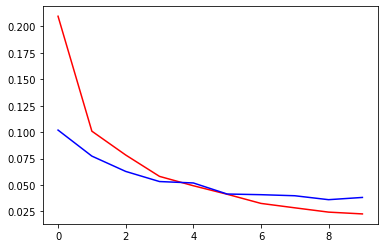

In [31]:
plt.plot(np.array(epoch_loss), 'r', np.array(val_epoch_loss), 'b')

In [40]:
predictions = predict(trial_model, sentences)

Output()

In [41]:
evaluate_argument_identification(labels, predictions, null_tag="_")


{'true_positives': 4240,
 'false_positives': 1038,
 'false_negatives': 773,
 'precision': 0.8033345964380447,
 'recall': 0.8458009176142031,
 'f1': 0.8240209892138763}

In [42]:
evaluate_argument_classification(labels, predictions, null_tag="_")

{'true_positives': 4040,
 'false_positives': 1238,
 'false_negatives': 973,
 'precision': 0.7654414550966275,
 'recall': 0.8059046479154199,
 'f1': 0.785152074628316}

In [43]:
def get_confusion_matrix(labels, predictions):
  lin_labels, lin_preds = [],[]
  for sentence_id in labels:
      gold = labels[sentence_id]["roles"]
      pred = predictions[sentence_id]["roles"]
      
      predicate_indices = set(gold.keys()).union(pred.keys())
      for idx in predicate_indices:
        if idx in gold and idx in pred: #both contain
          lin_labels.extend(gold[idx])
          lin_preds.extend(pred[idx])
  assert len(lin_labels)==len(lin_preds)
  m = confusion_matrix(lin_labels, lin_preds, labels=tags)
  return m

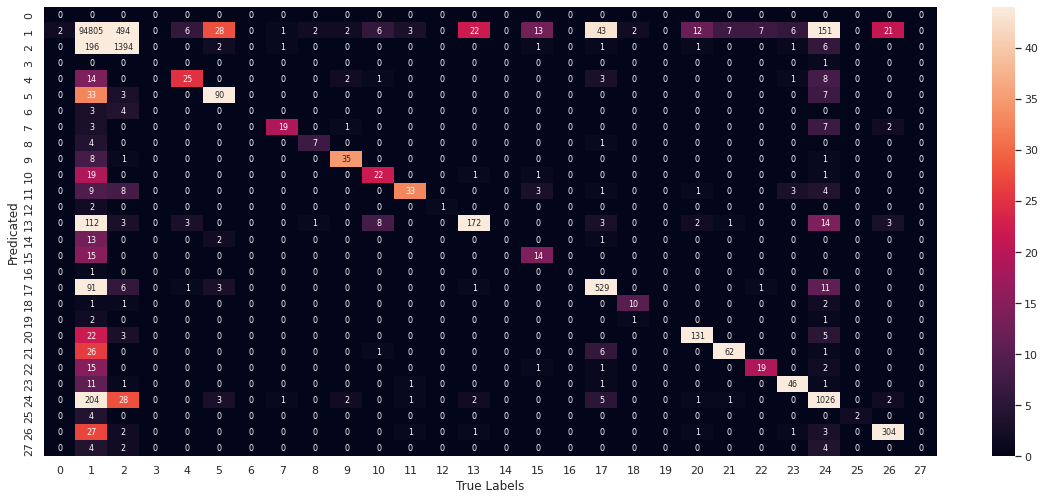

In [36]:
cf_matrix = get_confusion_matrix(labels, predictions)
sns.set(font_scale=0.4) # for label size
sns.set(rc={'figure.figsize':(20,8.27)})

s = sns.heatmap(cf_matrix, annot=True,fmt="d", annot_kws={"size": 8}, robust=True)
s.set(xlabel='True Labels', ylabel='Predicated')

plt.show()
